

# Epoching, averaging and noise covariance matrix

This notebook demonstrates how event information and epochs can be extracted from raw data to compute event-related potentials and fields. It also shows how to compute a noise covariance matrix for epoched data, and perform regression .

In [2]:
# This notebook is based on MNE-Python tutorials and examples, e.g.
# https://mne.tools/stable/auto_tutorials/epochs/10_epochs_overview.html
# https://mne.tools/stable/auto_tutorials/epochs/20_visualize_epochs.html
# https://mne.tools/stable/auto_tutorials/forward/90_compute_covariance.html
# https://mne.tools/stable/auto_tutorials/preprocessing/55_setting_eeg_reference.html
# https://mne.tools/stable/auto_examples/stats/sensor_regression.html

# Modified by Olaf Hauk, olaf.hauk@mrc-cbu.cam.ac.uk
# These notebooks complement the online lectures "Introduction to EEG/MEG analysis":
# https://www.youtube.com/playlist?list=PLp67eqWCj2f_DBsCMkIOBpBbLWGAUKtu5

Here, we will create epochs from raw data and average them to obtain event-related potentials in an event-related experimental paradigm.

In [1]:
import os

import numpy as np

import mne

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(
    sample_data_folder, "MEG", "sample", "sample_audvis_filt-0-40_raw.fif"
)
raw = mne.io.read_raw_fif(sample_data_raw_file, verbose=False)
events_file = os.path.join(
    sample_data_folder, "MEG", "sample", "sample_audvis_filt-0-40_raw-eve.fif"
)
events = mne.read_events(events_file)

event_id = {
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
    "face": 5,
    "button": 32,
}


## Rejecting Epochs based on peak-to-peak channel amplitude

We can set maximum acceptable peak-to-peak amplitudes for each channel type in an epoch, using
the ``reject`` parameter. <br>
There is also a related parameter, ``flat``, that can be used to set *minimum* acceptable peak-to-peak amplitudes for each channel type in an epoch. <br>
Note that these values will vary across different recording sites, systems, and participant groups.



In [3]:
reject_criteria = dict(
    mag=3000e-15,  # 3000 fT
    grad=3000e-13,  # 3000 fT/cm
    eeg=100e-6,  # 100 µV
    eog=150e-6,
)  # 200 µV

flat_criteria = dict(mag=1e-15, grad=1e-13, eeg=1e-6)  # 1 fT  # 1 fT/cm  # 1 µV

The values that are appropriate are dataset- and hardware-dependent, so some
trial-and-error may be necessary to find the correct balance between data
quality and loss of power due to too many dropped epochs. Here, we've set the
rejection criteria to be fairly stringent, for illustration purposes.

Two additional parameters, ``reject_tmin`` and ``reject_tmax``, are used to
set the temporal window in which to calculate peak-to-peak amplitude for the
purposes of epoch rejection. These default to the same ``tmin`` and ``tmax``
of the entire epoch. <br>
As one example, if you wanted to only apply the
rejection thresholds to the portion of the epoch that occurs *before* the
event marker around which the epoch is created, you could set
``reject_tmax=0``.



In [4]:
# we are applying an appropriate low-pass filter.
raw.load_data().filter(l_freq=None, h_freq=45)

epochs = mne.Epochs(
    raw,
    events,
    event_id=event_id,
    tmin=-0.2,
    tmax=0.5,
    reject_tmax=0,
    reject=reject_criteria,
    flat=flat_criteria,
    preload=True,
)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 45 samples (0.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.7s


Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Using data from preloaded Raw for 319 events and 106 original time points ...
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EEG : ['EEG 007']
    Rejecting  epoch based on EEG : ['EEG 003']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  e

Let's see what we got as Epochs object:

In [11]:
epochs

<Epochs | 304 events (all good), -0.2 – 0.499 s (baseline -0.2 – 0 s), ~95.6 MiB, data loaded,
 'auditory/left': 70
 'auditory/right': 69
 'visual/left': 72
 'visual/right': 63
 'face': 15
 'button': 15>

We are interested in how many epochs have been rejected, and why. <br>
The output of the epoching above already gives us a clear idea of the main reasons for epoch rejections. <br>A **useful summary** of the causes of rejected epochs can be generated with the :meth:`~mne.Epochs.plot_drop_log` method:

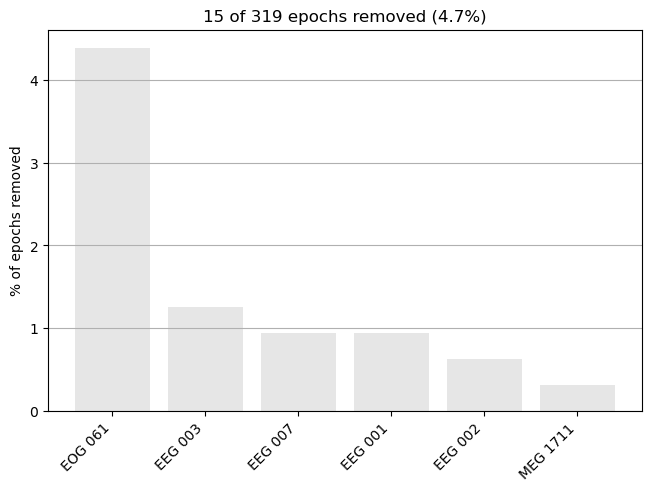

In [7]:
epochs.plot_drop_log();

The :meth:`~mne.Epochs.plot_drop_log` method is a visualization of an
:class:`~mne.Epochs` attribute, namely ``epochs.drop_log``, which stores
empty lists for retained epochs and lists of strings for dropped epochs, with
the strings indicating the reason(s) why the epoch was dropped. For example:



In [8]:
print(epochs.drop_log)

((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('EEG 001', 'EEG 002', 'EEG 003', 'EEG 007', 'EOG 061'), ('EOG 061',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('EEG 001', 'EEG 003', 'EEG 007', 'EOG 061'), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('EOG 061',), (), ('EOG 061',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('MEG 1711',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('EOG 061',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('EOG 061',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('EOG 0

We note that most epochs have been rejected due to high amplitudes in our EOG channel, pointing to eye blinks as the cause. We can plot the individual epochs to check: 

In [15]:
epochs.plot(picks='eog', events=events, event_id=event_id)

You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


<mne_qt_browser._pg_figure.MNEQtBrowser(0x24b67a09e20) at 0x0000024B724C5A80>

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
['MEG 2443', 'EEG 053']


C:\Users\olaf\AppData\Local\mne-python\1.8.0_0\mne1.9.0\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


**Exercise:** <br>
- Match up the information from the 'drop log' above with the corresponding epoch data in this plot.

In a "real" experiment we would now have to decide whether we want to play safe and accept a ~15% loss of epochs due to eye blinks, or whether we want to correct eye blink artefacts (e.g. using ICA). <br>
The latter may not fully correct for the whole artefact, and subtle effects of eye blinks may remain in the data. <br>
If eye blinks may systematically vary with our variable of interest (e.g. between conditions), then it might be safer to reject these epochs.

If rejection thresholds were not originally given to the
:class:`~mne.Epochs` constructor, they can be passed to
:meth:`~mne.Epochs.drop_bad` later instead. <br>
This can also be a way of imposing progressively more stringent rejection criteria:


In [18]:
stronger_reject_criteria = dict(
    mag=2000e-15,  # 2000 fT
    grad=2000e-13,  # 2000 fT/cm
    eeg=100e-6,  # 100 µV
    eog=100e-6,
)  # 100 µV

epochs.drop_bad(reject=stronger_reject_criteria)
print(epochs.drop_log)

0 bad epochs dropped
((), (), ('MEG 0111', 'MEG 0141', 'MEG 1411', 'MEG 1421', 'MEG 1431', 'MEG 1541'), (), (), ('MEG 0111', 'MEG 0141', 'MEG 1421', 'MEG 1431', 'MEG 1541', 'MEG 2621'), (), (), ('MEG 0111', 'MEG 0141', 'MEG 1411', 'MEG 1421', 'MEG 1431', 'MEG 1441', 'MEG 1541', 'MEG 2621'), (), (), (), ('MEG 0111', 'MEG 0141', 'MEG 1421', 'MEG 1431', 'MEG 1541', 'MEG 2621'), (), (), (), ('EEG 001', 'EEG 002', 'EEG 003', 'EEG 007', 'EOG 061'), ('EOG 061',), (), (), (), (), ('MEG 0141', 'MEG 1421', 'MEG 1431', 'MEG 1541', 'MEG 2621'), (), (), (), ('MEG 0111', 'MEG 0141', 'MEG 1421', 'MEG 1431'), (), (), ('MEG 0111', 'MEG 0141', 'MEG 1411', 'MEG 1421', 'MEG 1431', 'MEG 1541', 'MEG 2621'), (), (), (), (), (), (), ('MEG 0111', 'MEG 0141', 'MEG 1421', 'MEG 1431', 'MEG 1541', 'MEG 2621'), (), (), (), (), ('EEG 001', 'EEG 003', 'EEG 007', 'EOG 061'), (), ('MEG 0111', 'MEG 0141', 'MEG 1411', 'MEG 1421', 'MEG 1431', 'MEG 1541', 'MEG 2621'), ('EOG 061',), (), ('MEG 1421', 'MEG 1431', 'MEG 2621'),

**Exercise:** <br>
- Try different rejections thresholds for different sensor types and see what happens. <br>
Note that successive applications of 'drop_bad' require increasingly more stringent rejection criteria. You may therefore have to recreate the original epochs object.

The complementary Python module, the `autoreject package`, uses
machine learning to find optimal rejection criteria, and is designed to
integrate smoothly with MNE-Python workflows. This can be a considerable
time-saver when working with heterogeneous datasets.

We can also compute and plot spectra for epoched data, for example:

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Averaging across epochs before plotting...


C:\Users\olaf\AppData\Local\mne-python\1.8.0_0\mne1.9.0\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


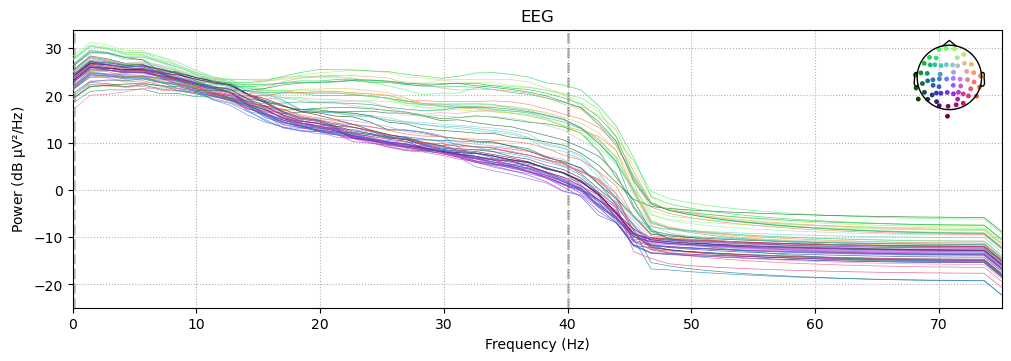

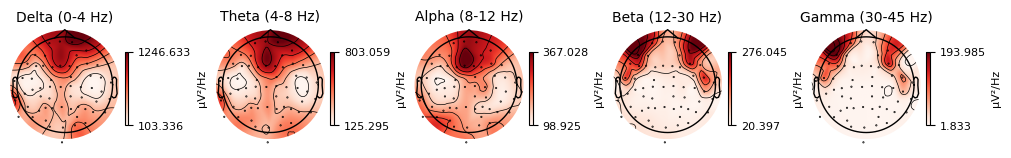

In [27]:
spectrum = epochs["face"].copy().pick_types(meg=False, eeg=True).compute_psd(exclude='bads')
spectrum.plot(amplitude=False);
spectrum.plot_topomap();

**Exercise:** <br>
- Plot topographies for your own frequency ranges. <br>
Hint: Check the documentation for 'plot_topomap' for ways to specify frequency bands.

We note that there is a lot of activity in frontal sensors in all frequency bands. This is likely to be residual eye blink or eye movement activity.

We can try to locate the faulty channel(s) in the layout:

We can plot timecourses across epochs and matrix plots :

Not setting metadata
103 matching events found
No baseline correction applied
0 projection items activated
combining channels using RMS (grad channels)


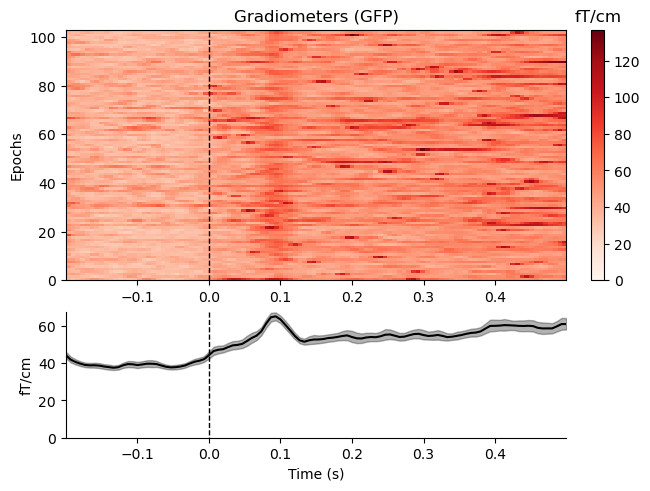

[<Figure size 640x480 with 3 Axes>]

In [28]:
epochs["auditory"].plot_image(picks="grad", combine="gfp")

It is more impressive if we plot timecourses for individual channels:

Not setting metadata
103 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
103 matching events found
No baseline correction applied
0 projection items activated


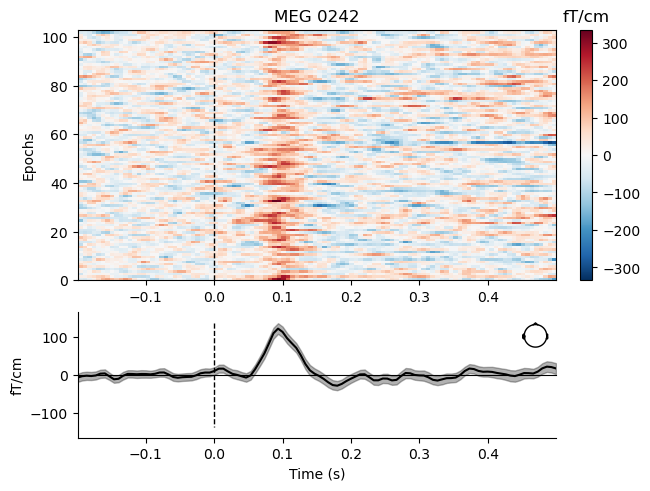

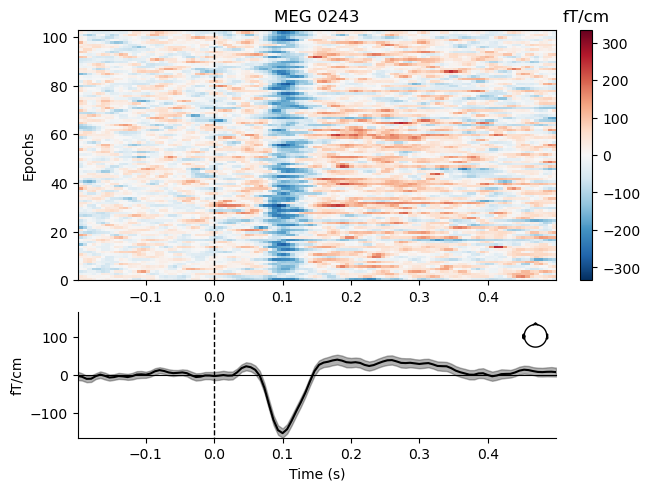

In [29]:
epochs["auditory"].plot_image(picks=["MEG 0242", "MEG 0243"]);

Note that single-trial responses pop out in this view, at least for early "components".

# EEG reference

The epoched EEG data were automatically referenced to 'average reference', i.e. the average voltage across electrodes was subtracted at all EEG channels at each time point. <br>
This distributes the "responsibility" of the reference across all channels, and the time course does not depend on the arbitrary selection of an individual electrode. Also note that the average across the voltage distribution over any closed surface around the brain is zero, which the "average reference" approximates.


The raw data contain a "projection" for the average reference that can be switched on or off on demand. <br>Let's check the effect of average-referencing EEG data on their time courses.

In [31]:
raw.plot(picks='eeg', proj=False)
raw.plot(picks='eeg', proj=True)

<mne_qt_browser._pg_figure.MNEQtBrowser(0x24b63935360) at 0x0000024B7DCCAE40>

Channels marked as bad:
['MEG 2443', 'EEG 053']


C:\Users\olaf\AppData\Local\mne-python\1.8.0_0\mne1.9.0\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


Channels marked as bad:
['MEG 2443', 'EEG 053']


The effect of (not) average-referencing if you look at eye blink activity across EEG channels.

Note that before average-referencing all time courses look very similar - because they are all referenced to the same reference electrode.

Now let's check that our epochs are indeed average-referenced:

In [32]:
print(raw.info)
print(epochs.info)

<Info | 14 non-empty values
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off, Average EEG reference: off
 sfreq: 150.2 Hz
>
<Info | 14 non-empty values
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpa

If the EEG reference has not been specified before, we could do it now:

In [34]:
# Default: average reference
epochs.set_eeg_reference()
# Note: We could add the reference as a 'projection' and switch it on or off later with epochs.apply_proj()

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Created an SSP operator (subspace dimension = 3)


<Epochs | 227 events (all good), -0.2 – 0.499 s (baseline -0.2 – 0 s), ~72.2 MiB, data loaded,
 'auditory/left': 56
 'auditory/right': 47
 'visual/left': 52
 'visual/right': 51
 'face': 11
 'button': 10>

# Averaging - evoked responses

In many studies, we are interested in "evoked" or "event-related" responses for different stimulus categories in our data, i.e. averages across epochs for the same type of stimulus ("conditions").

It is easy to compute averages for each individual condition in the Epochs object, and obtain a list of Evoked objects:

In [35]:
evokeds = epochs.average(by_event_type=True)
evokeds

[<Evoked | 'auditory/left' (average, N=56), -0.1998 – 0.49949 s, baseline -0.199795 – 0 s, 366 ch, ~3.5 MiB>,
 <Evoked | 'auditory/right' (average, N=47), -0.1998 – 0.49949 s, baseline -0.199795 – 0 s, 366 ch, ~3.5 MiB>,
 <Evoked | 'visual/left' (average, N=52), -0.1998 – 0.49949 s, baseline -0.199795 – 0 s, 366 ch, ~3.5 MiB>,
 <Evoked | 'visual/right' (average, N=51), -0.1998 – 0.49949 s, baseline -0.199795 – 0 s, 366 ch, ~3.5 MiB>,
 <Evoked | 'face' (average, N=11), -0.1998 – 0.49949 s, baseline -0.199795 – 0 s, 366 ch, ~3.5 MiB>,
 <Evoked | 'button' (average, N=10), -0.1998 – 0.49949 s, baseline -0.199795 – 0 s, 366 ch, ~3.5 MiB>]

We can plot them one-by-one (note the different numbers of averages in above output):

auditory/left


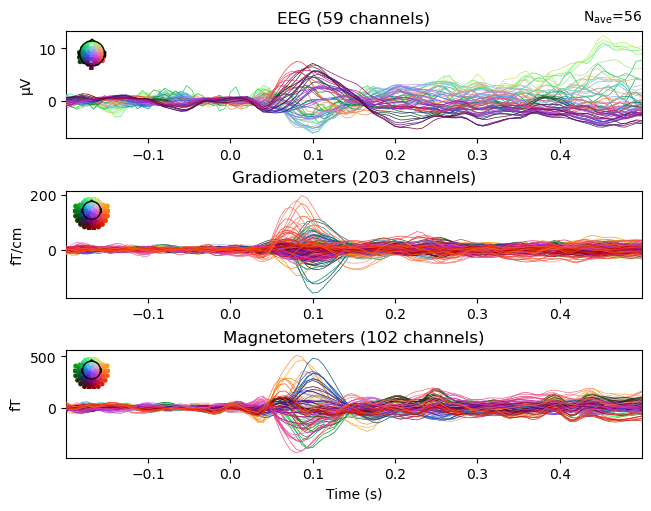

Projections have already been applied. Setting proj attribute to True.


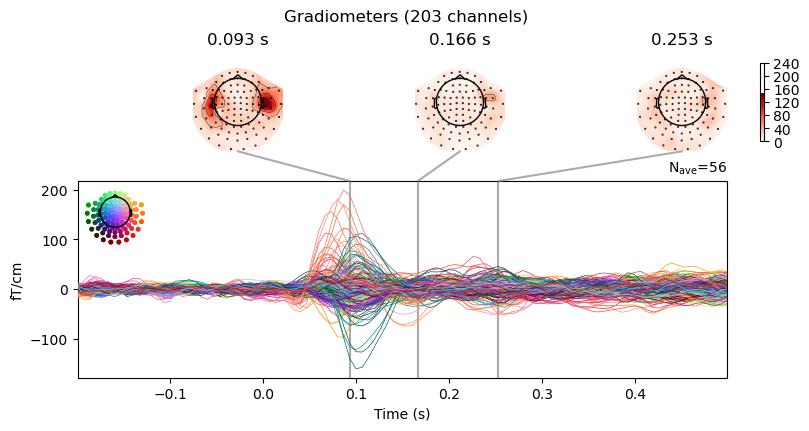

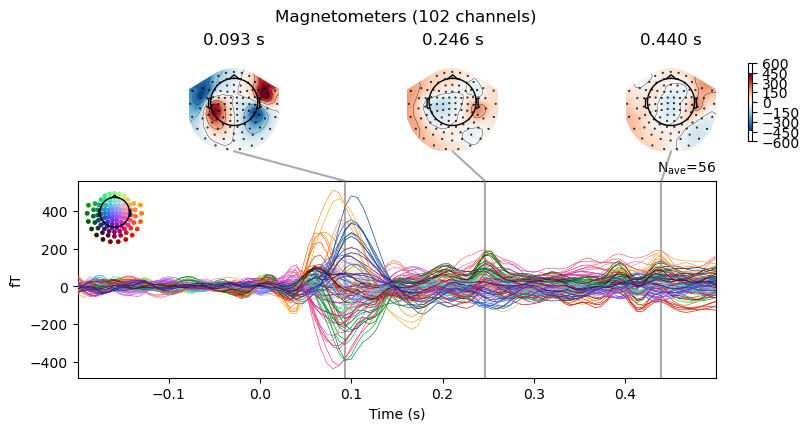

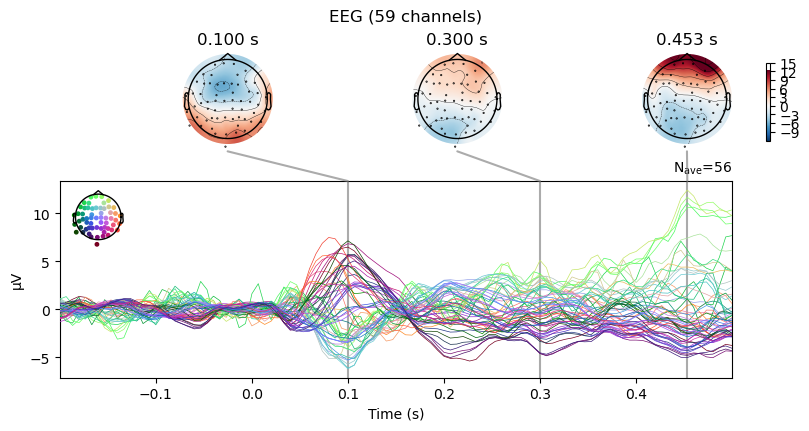

In [39]:
i = 0  # index of condition in list
print(evokeds[i].comment)  # name of condition
evokeds[i].plot();  # plot time courses only
evokeds[i].plot_joint();  # plot time courses with topographies

We can use condition names (and sub-strings) to reference stimulus categories in Epochs objects:

In [45]:
evoked = epochs["auditory/left"].average()
evoked

<Evoked | 'auditory/left' (average, N=56), -0.1998 – 0.49949 s, baseline -0.199795 – 0 s, 366 ch, ~3.5 MiB>

**Exercise:** <br>
- What happens if you use incomplete condition names as indices, e.g. ["auditory"]? <br>
Hint: Look at the number of averaged epochs.

We can access the evoked data as a numpy array:

In [47]:
print(evoked.data.shape)
print(evoked.data.min(), evoked.data.max())

(366, 106)
-6.1878448973901315e-06 1.2440546020128625e-05


We can change the baseline:

Applying baseline correction (mode: mean)


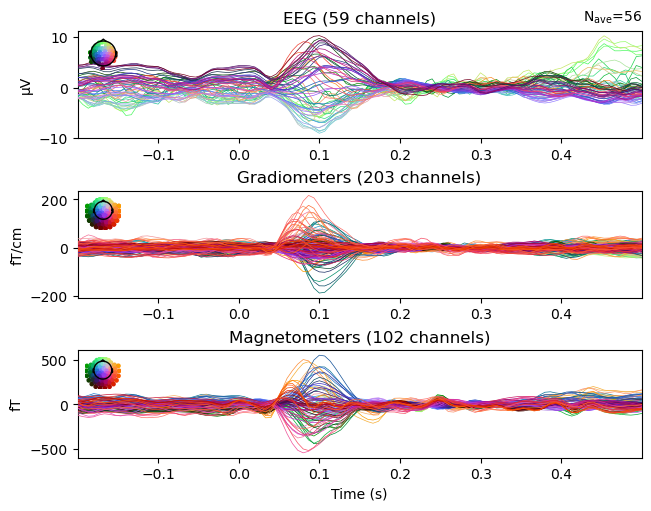

In [25]:
# We are using a non-sensical post-stimulus baseline here just for illustration purposes.
evoked.apply_baseline((.2, .3)).plot();

**Exercise:** <br>
- Choose different baseline intervals and inspect the effects in the plots.

We can combine conditions before or after averaging:

In [48]:
# Before averaging - use all "auditory" condition (i.e. collapse across "left" and "right")
left_right_aud = epochs["auditory"].average()
print(left_right_aud)

# After avering - computed averages weighted by trial counts
left_aud = epochs["auditory/left"].average()
right_aud = epochs["auditory/right"].average()
print("Number of averages for 'left auditory: %d', 'right auditory': %d" % (left_aud.nave, right_aud.nave))
left_right_aud = mne.combine_evoked([left_aud, right_aud], weights="nave")
print(left_right_aud)

<Evoked | '0.54 × auditory/left + 0.46 × auditory/right' (average, N=103), -0.1998 – 0.49949 s, baseline -0.199795 – 0 s, 366 ch, ~3.5 MiB>
Number of averages for 'left auditory: 56', 'right auditory': 47
<Evoked | '0.544 × auditory/left + 0.456 × auditory/right' (average, N=103.00000000000001), -0.1998 – 0.49949 s, baseline -0.199795 – 0 s, 366 ch, ~3.5 MiB>


We can extract peak information from Evoked objects:

In [49]:
for evoked in [left_aud, right_aud]:
    ch, lat, amp = evoked.get_peak(ch_type='eeg', tmin=0.05, tmax=0.15, return_amplitude=True)
    print("%s: %s, %.2fms, %fuV" % (evoked.comment, ch, 1000*lat, 1e6*amp))

auditory/left: EEG 043, 79.92ms, 7.495957uV
auditory/right: EEG 044, 93.24ms, 6.411307uV


# (Noise) Covariance Matrix, "Whitening"

For some processing steps we need a (noise) covariance matrix, e.g. to scale and combine sensor types in source estimation. <br>
In some contexts this is called "data whitening", because it transforms the data such that the result has uncorrelated time courses ("white noise"). <br>
Let's start by computing a noise covariance matrix from data in the baseline interval.

In [58]:
# with method='auto' the method picks the best option for whitening
noise_cov = mne.compute_covariance(epochs, tmax=0., method='auto')

    Created an SSP operator (subspace dimension = 3)
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 364 -> 360
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
    GRAD regularization : 0.1
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    MAG regularization : 0.1
    GRAD regularization : 0.1
    EEG regularization : 0.1
    MAG regularization : 0.1
    GRAD regularization : 0.1
    EEG regularization : 0.1
    MAG regularization : 0.1
    GRAD regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 7037
log-likelihood on unseen data (descending order):
   shrunk: -1568.406
   empirical: -1574.168
   diagonal_fixed: -1615.218
selecting best estimator: shrunk
[done]


Note that this method computed the best covariance matrix out of several options, in this case option 'shrunk' is the winner.

We can plot the noise covariance matrices for separate sensor types. They should have a dominant diagonal. <br>
The exact structure will depend on sensor positions (neighbouring sensors tend to have higher covariance). 

Computing rank from covariance with rank=None
    Using tolerance 9.1e-15 (2.2e-16 eps * 102 dim * 0.4  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 1.5e-13 (2.2e-16 eps * 203 dim * 3.4  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 7.2e-14 (2.2e-16 eps * 59 dim * 5.5  max singular value)
    Estimated rank (eeg): 58
    EEG: rank 58 computed from 59 data channels with 0 projectors


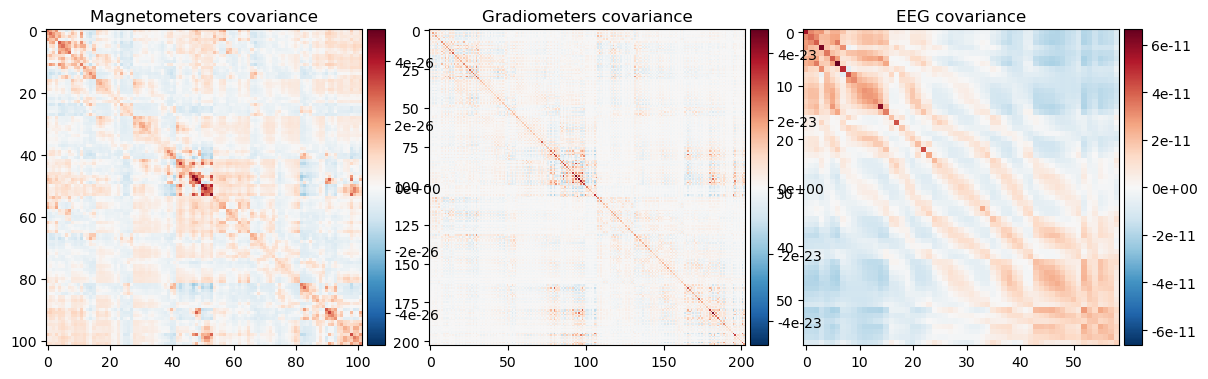

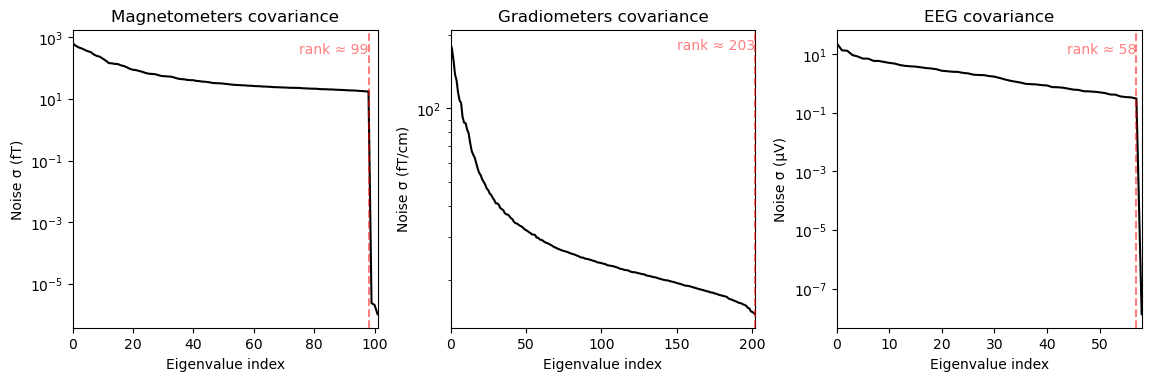

In [59]:
noise_cov.plot(epochs.info);

**Exercise:** <br>
- Try different latency intervals for the covariance estimation and check the effect in the plots. <br>
If the interval covers post-stimulus latencies, it becomes a "data" (rather than "noise") covariance matrix, which is for example required for beamforming. But does the latency interval change much?

We can **use the noise covariance matrix to "whiten" the data**, which turns the data into signal-to-noise ratios. <br>
The baseline interval should then resemble a unit normal distribution.

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Computing rank from covariance with rank=None
    Using tolerance 7.2e-14 (2.2e-16 eps * 59 dim * 5.5  max singular value)
    Estimated rank (eeg): 58
    EEG: rank 58 computed from 59 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 1.5e-13 (2.2e-16 eps * 203 dim * 3.4  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 9.1e-15 (2.2e-16 eps * 102 dim * 0.4  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 3 projectors
    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank={'eeg': 58, 'grad': 203, 'mag': 99, 'meg': 302}
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
    Cre

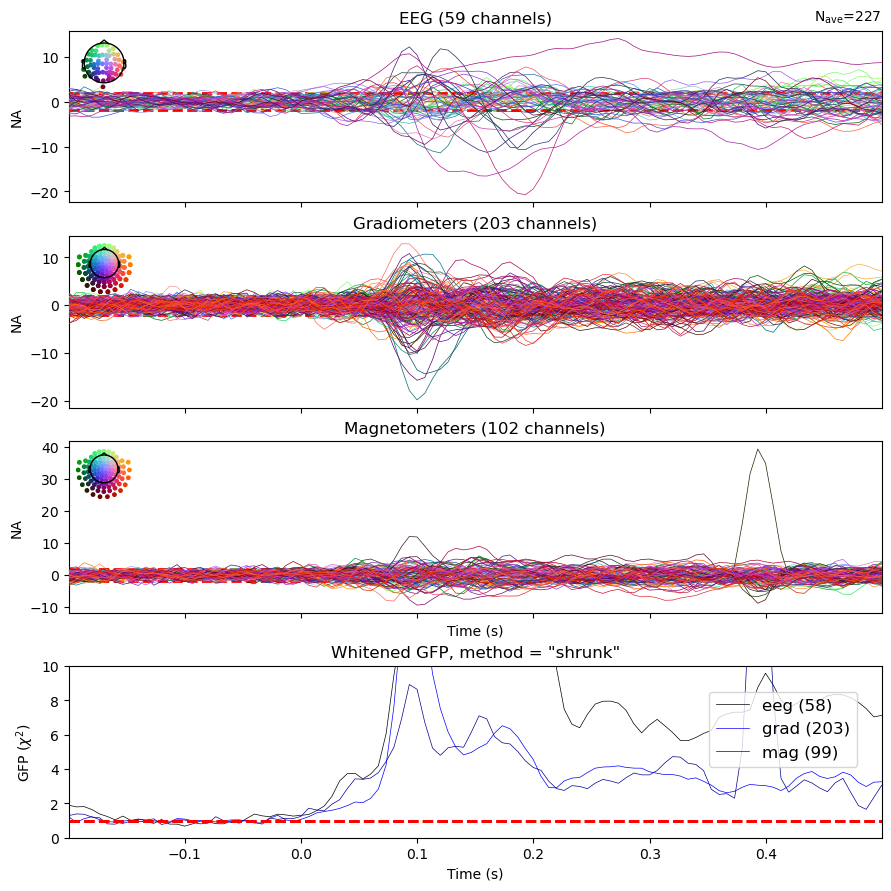

In [60]:
evoked = epochs.average()
evoked.plot_white(noise_cov);

Note that the baseline values of the whitenend data are within +/- one standard deviation and the global field power is close to one for all sensor types. After whitening the data are interpretable as SNRs, and therefore comparable across sensor types.

We can also plot raw data and epochs in their whitened form by supplying a noise covariance matrix when plotting.

# Regression analysis

Instead of averaging trials within conditions for factorial statistical analysis, we can define continuous variables across epochs and use them for regression analysis. We need to specify the regressors as "metadata" in a dataframe.

In [61]:
import pandas as pd  # metadata will be Pandas dataframe
from scipy.stats import zscore

Let's pretend we are interested in two variables: <br>
1) the linear trend over trials in our data.
2) the root-mean-square (RMS) in an early latency window per epoch.

In [62]:
epochs = epochs['auditory']  # let's restrict ourselves to auditory trials

trialnr = np.arange(len(epochs))
trialnr = zscore(trialnr)  # z-scored trial number
metadata = pd.DataFrame(data={'TrialNr': trialnr})  # create dataframe for regression

Add the RMS for the EEG epochs in an early time window as regressor.

In [65]:
eegrms = [np.sqrt(np.sqrt(epoch**2).mean()) for epoch in epochs.copy().crop(0.05, 0.15).pick(picks='eeg')]
metadata['EEGRMS'] = zscore(eegrms)

In [66]:
metadata = metadata.assign(Intercept=1)  # add an intercept

Let's inspect our dataframe:

In [67]:
print(metadata.head())

    TrialNr    EEGRMS  Intercept
0 -1.715316  3.352073          1
1 -1.681682 -0.070226          1
2 -1.648048 -1.336763          1
3 -1.614415 -2.022890          1
4 -1.580781  1.278126          1


Apply a linear regression model, including an intercept:

In [68]:
names = ["Intercept", "TrialNr", "EEGRMS"]
res = mne.stats.linear_regression(epochs, metadata[names], names=names)

Fitting linear model to epochs, (39856 targets, 3 regressors)
Done


C:\Users\olaf\AppData\Local\Temp\ipykernel_18788\1263835873.py:2: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = mne.stats.linear_regression(epochs, metadata[names], names=names)


The beta coefficients from the regression analysis can be treated like Evoked objects. In fact, they are similar to "difference waves" that we would have obtained by subtracting two conditions (e.g. "high trial numbers" minus "low trial numbers"). <br>
Let's plot them:

Projections have already been applied. Setting proj attribute to True.


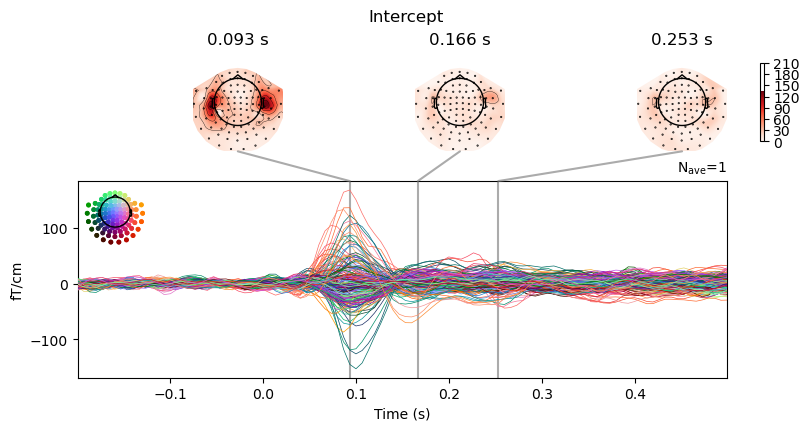

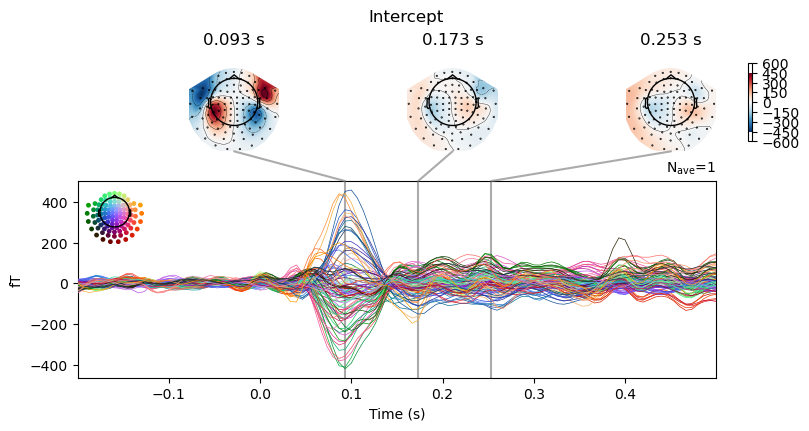

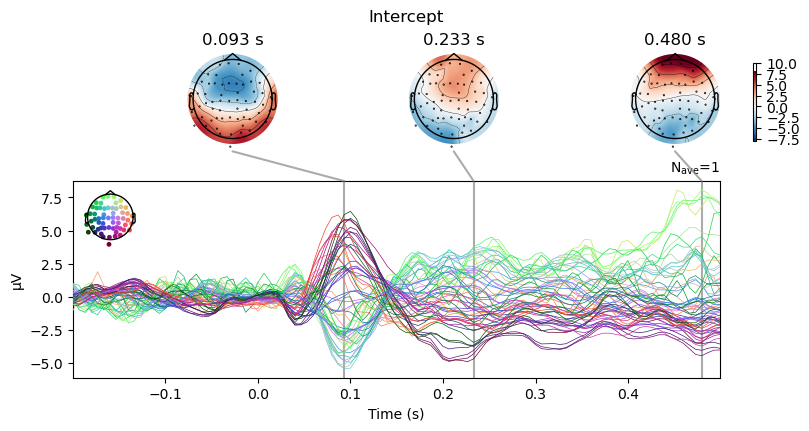

Projections have already been applied. Setting proj attribute to True.


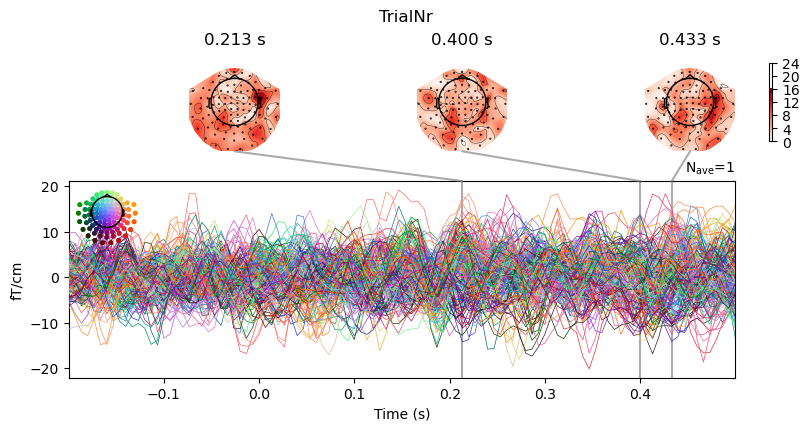

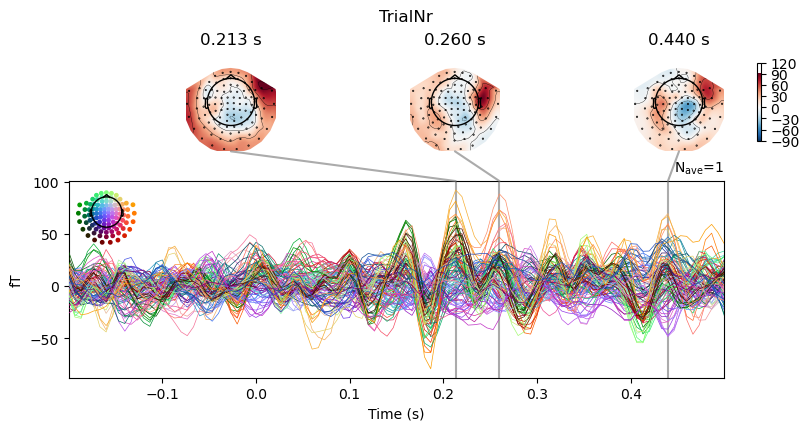

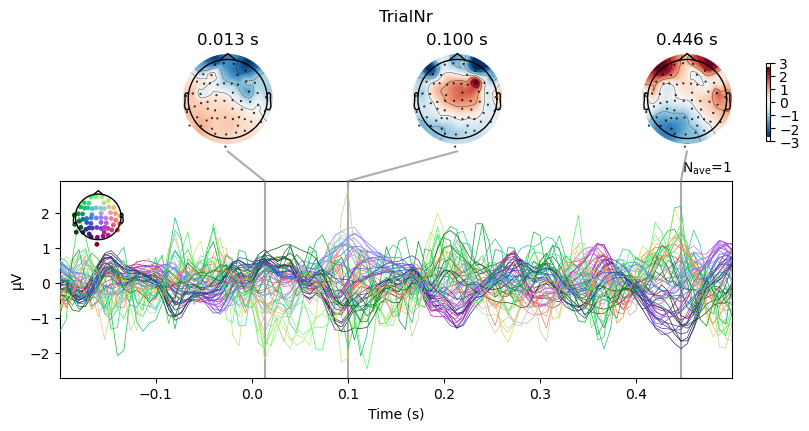

Projections have already been applied. Setting proj attribute to True.


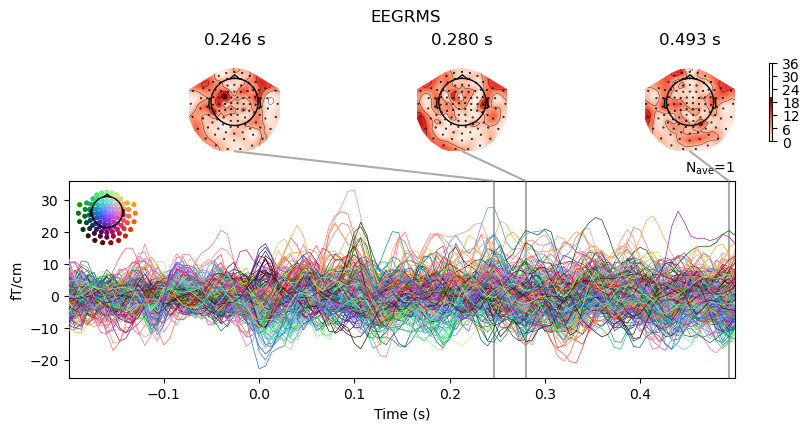

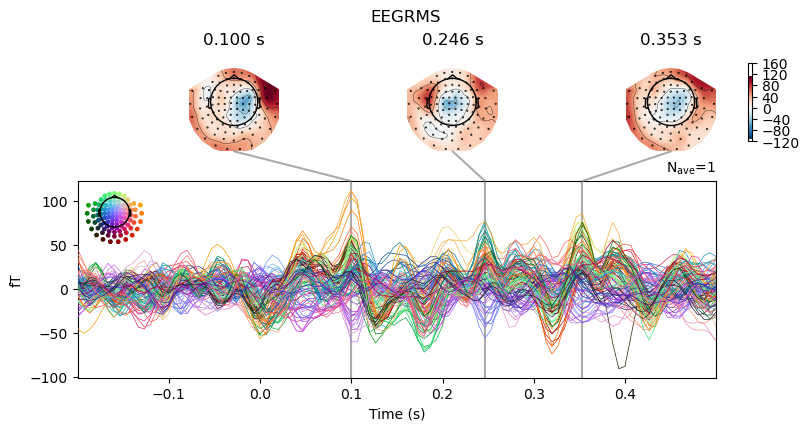

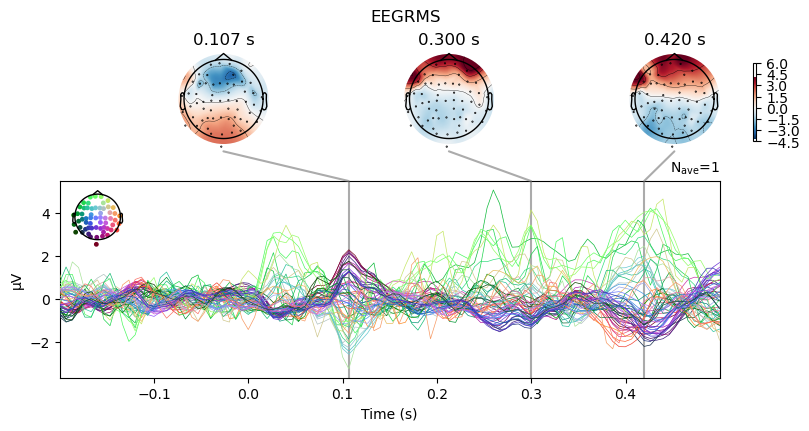

Channels marked as bad:
['MEG 2443', 'EEG 053']


C:\Users\olaf\AppData\Local\mne-python\1.8.0_0\mne1.9.0\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


Channels marked as bad:
['MEG 2443', 'EEG 053']


In [71]:
for cond in names:
    res[cond].beta.plot_joint(
        title=cond, ts_args=dict(time_unit="s"), topomap_args=dict(time_unit="s")
    );

The beta coefficients for Intercept produce the average evoked response across trials.

Trial number betas are quite noisy and hard to interpret - it doesn't seem to have a large effect on brain responses in this case. Probably not surprising for these simple stimuli in a relatively short session.

It is not surprising - but reassuring - that EEG amplitudes correlate with themselves in several latency ranges. It is a bit more surprising - and also reassuring - that EEG amplitudes also correlate with MEG amplitudes.

**Exercise:** <br>
- Play around with the predictors, e.g. use other latency ranges for the RMS computation.
- Can you think of any other predictors?